# Graph Neural Network for User Clustering

### Install Libraries

In [1]:
pip install torch_geometric

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import GRU
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader
import networkx as nx

### Load Data

In [3]:
data = pd.read_csv('data/raw_data.csv')

In [4]:
data.head()

,User ID,Phone,Gender,Age,Weight,Height,Date/Time,Tiredness,Calm,Nutrition,...,Actions,With,Reflections,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake
0,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-22T10:18:14.805Z,50.0,100.0,91.0,...,Social media,Family,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T08:24:41.507Z,50.0,50.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T18:39:49.540Z,100.0,100.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T23:00:04.538Z,50.0,50.0,50.0,...,NaN,Friends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-26T11:02:15.078Z,41.0,96.0,26.0,...,Travel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
len(list(data['User ID'].unique()))

145

In [6]:
data.columns

Index(['User ID', 'Phone', 'Gender', 'Age', 'Weight', 'Height', 'Date/Time',
       'Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance',
       'Concentrate', 'Happy', 'Determined', 'Excited', 'Loving', 'Motivated',
       'Powerful', 'Helpful', 'Lively', 'Peaceful', 'Proud', 'Optimistic',
       'Valued', 'Content', 'Hopeful', 'Confident', 'Relieved', 'Annoyed',
       'Nervous', 'Overwhelmed', 'Irritated', 'Anxious', 'Afraid', 'Angry',
       'Worried', 'Bored', 'Lonely', 'Weary', 'Disappointed', 'Confused',
       'Embarrassed', 'Sad', 'Actions', 'With', 'Reflections', 'Steps',
       'Sleep', 'HRV', 'Sleep Heart Rate', 'Glucose', 'Callories Burn',
       'Calories Intake'],
      dtype='object')

In [7]:
df= pd.read_csv('data/raw_data.csv')

In [8]:
dfo = df

In [9]:
df.columns

Index(['User ID', 'Phone', 'Gender', 'Age', 'Weight', 'Height', 'Date/Time',
       'Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance',
       'Concentrate', 'Happy', 'Determined', 'Excited', 'Loving', 'Motivated',
       'Powerful', 'Helpful', 'Lively', 'Peaceful', 'Proud', 'Optimistic',
       'Valued', 'Content', 'Hopeful', 'Confident', 'Relieved', 'Annoyed',
       'Nervous', 'Overwhelmed', 'Irritated', 'Anxious', 'Afraid', 'Angry',
       'Worried', 'Bored', 'Lonely', 'Weary', 'Disappointed', 'Confused',
       'Embarrassed', 'Sad', 'Actions', 'With', 'Reflections', 'Steps',
       'Sleep', 'HRV', 'Sleep Heart Rate', 'Glucose', 'Callories Burn',
       'Calories Intake'],
      dtype='object')

In [10]:
df = df[['User ID','Date/Time',
       'Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance',
       'Concentrate', 'Happy', 'Determined', 'Excited', 'Loving', 'Motivated',
       'Powerful', 'Helpful', 'Lively', 'Peaceful', 'Proud', 'Optimistic',
       'Valued', 'Content', 'Hopeful', 'Confident', 'Relieved', 'Annoyed',
       'Nervous', 'Overwhelmed', 'Irritated', 'Anxious', 'Afraid', 'Angry',
       'Worried', 'Bored', 'Lonely', 'Weary', 'Disappointed', 'Confused',
       'Embarrassed', 'Sad']]

In [11]:
emotion_columns = ['Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance',
       'Concentrate', 'Happy', 'Determined', 'Excited', 'Loving', 'Motivated',
       'Powerful', 'Helpful', 'Lively', 'Peaceful', 'Proud', 'Optimistic',
       'Valued', 'Content', 'Hopeful', 'Confident', 'Relieved', 'Annoyed',
       'Nervous', 'Overwhelmed', 'Irritated', 'Anxious', 'Afraid', 'Angry',
       'Worried', 'Bored', 'Lonely', 'Weary', 'Disappointed', 'Confused',
       'Embarrassed', 'Sad']

In [12]:
dfo

,User ID,Phone,Gender,Age,Weight,Height,Date/Time,Tiredness,Calm,Nutrition,...,Actions,With,Reflections,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake
0,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-22T10:18:14.805Z,50.0,100.0,91.0,...,Social media,Family,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T08:24:41.507Z,50.0,50.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T18:39:49.540Z,100.0,100.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T23:00:04.538Z,50.0,50.0,50.0,...,NaN,Friends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-26T11:02:15.078Z,41.0,96.0,26.0,...,Travel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5806,v4HzUqmhkSdtZl0ZtrZWF9zMPwV2,447956024968,woman,21,71,168,2024-05-26T13:46:57.170Z,50.0,50.0,50.0,...,Cooking/eating,Partner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5807,v4HzUqmhkSdtZl0ZtrZWF9zMPwV2,447956024968,woman,21,71,168,2024-05-27T21:32:00.006Z,71.0,35.0,56.0,...,Shopping +Socialising,Partner+Myself+Friends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5808,v4HzUqmhkSdtZl0ZtrZWF9zMPwV2,447956024968,woman,21,71,168,2024-06-06T13:22:19.460Z,57.0,38.0,41.0,...,Gym,Partner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5809,v4HzUqmhkSdtZl0ZtrZWF9zMPwV2,447956024968,woman,21,71,168,2024-06-07T16:02:15.187Z,64.0,57.0,44.0,...,Tea/Coffee+Shopping,Partner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df = pd.DataFrame(df).sort_values(by=['User ID', 'Date/Time'])

In [14]:
dfo

,User ID,Phone,Gender,Age,Weight,Height,Date/Time,Tiredness,Calm,Nutrition,...,Actions,With,Reflections,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake
0,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-22T10:18:14.805Z,50.0,100.0,91.0,...,Social media,Family,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T08:24:41.507Z,50.0,50.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T18:39:49.540Z,100.0,100.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T23:00:04.538Z,50.0,50.0,50.0,...,NaN,Friends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-26T11:02:15.078Z,41.0,96.0,26.0,...,Travel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5806,v4HzUqmhkSdtZl0ZtrZWF9zMPwV2,447956024968,woman,21,71,168,2024-05-26T13:46:57.170Z,50.0,50.0,50.0,...,Cooking/eating,Partner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5807,v4HzUqmhkSdtZl0ZtrZWF9zMPwV2,447956024968,woman,21,71,168,2024-05-27T21:32:00.006Z,71.0,35.0,56.0,...,Shopping +Socialising,Partner+Myself+Friends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5808,v4HzUqmhkSdtZl0ZtrZWF9zMPwV2,447956024968,woman,21,71,168,2024-06-06T13:22:19.460Z,57.0,38.0,41.0,...,Gym,Partner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5809,v4HzUqmhkSdtZl0ZtrZWF9zMPwV2,447956024968,woman,21,71,168,2024-06-07T16:02:15.187Z,64.0,57.0,44.0,...,Tea/Coffee+Shopping,Partner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df[emotion_columns] = df[emotion_columns]/100

In [16]:
G = nx.Graph()
corr_matrix = df[emotion_columns].corr(method='pearson')
for i in range(len(emotion_columns)):
    for j in range(i+1, len(emotion_columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.5:
            G.add_edge(i, j)

In [17]:
edge_index = torch.tensor(list(G.edges)).t().contiguous()
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

In [18]:
class EmotionDataset(Dataset):
    def __init__(self, df, emotion_columns):
        self.sequences = []
        self.masks = []
        self.user_ids = df['User ID'].unique()
        for uid in self.user_ids:
            user_df = df[df['User ID'] == uid].sort_values(by='Date/Time')
            x = user_df[emotion_columns].values
            mask = ~np.isnan(x)
            x[np.isnan(x)] = 0
            self.sequences.append(torch.tensor(x, dtype=torch.float))  # [T, F]
            self.masks.append(torch.tensor(mask, dtype=torch.bool))    # [T, F]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.masks[idx]

In [19]:
dataset = EmotionDataset(df, emotion_columns)


In [20]:
class TGNN(torch.nn.Module):
    def __init__(self, num_emotions, hidden_channels):
        super(TGNN, self).__init__()
        self.gcn = GCNConv(1, hidden_channels)  # One feature per emotion (node)
        self.gru = GRU(hidden_channels, hidden_channels, batch_first=True)
        self.fc_out = torch.nn.Linear(hidden_channels, 1)  # One output per node

    def forward(self, x_seq, edge_index):
        # x_seq: [B, T, F] (batch, time, features/emotions)
        B, T, F = x_seq.size()
        output_seq = []

        for b in range(B):
            node_seq = []
            for t in range(T):
                x_t = x_seq[b, t].unsqueeze(-1)  # [F, 1]
                gnn_out = self.gcn(x_t, edge_index)  # [F, hidden]
                node_seq.append(gnn_out)  # [F, H]

            node_seq = torch.stack(node_seq, dim=0)  # [T, F, H]
            node_seq = node_seq.permute(1, 0, 2)     # [F, T, H] → process each emotion across time

            # Process each node (emotion) as its own time series
            gru_out = []
            for f in range(F):
                out, _ = self.gru(node_seq[f].unsqueeze(0))  # [1, T, H]
                out = self.fc_out(out).squeeze(-1)           # [1, T]
                gru_out.append(out.squeeze(0))               # [T]

            user_output = torch.stack(gru_out, dim=1)        # [T, F]
            output_seq.append(user_output)

        return torch.stack(output_seq)  # [B, T, F]


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
np.random.seed(42)

In [23]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Dataloader remains the same (ensure collate_fn returns zipped sequences and masks)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: list(zip(*x)))

model = TGNN(num_emotions=len(emotion_columns), hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(51):
    total_loss = 0
    model.train()
    for batch_x, batch_mask in dataloader:
        batch_x = list(batch_x)
        batch_mask = list(batch_mask)
        lengths = [seq.shape[0] for seq in batch_x]
        max_len = max(lengths)

        # Pad sequences to max length in batch
        padded_x = torch.stack([F.pad(seq, (0, 0, 0, max_len - seq.shape[0])) for seq in batch_x])       # [B, T, F]
        padded_mask = torch.stack([F.pad(mask, (0, 0, 0, max_len - mask.shape[0])) for mask in batch_mask])  # [B, T, F]

        padded_x = padded_x.to(device)         # [B, T, F]
        padded_mask = padded_mask.to(device)   # [B, T, F]
        edge_index_device = edge_index.to(device)
        pred = model(padded_x, edge_index_device)  # Output: [B, T, F]

        loss = F.mse_loss(pred[padded_mask], padded_x[padded_mask])  # Compute loss only on observed values
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {total_loss:.4f}")


Epoch 0 | Loss: 3.8628
Epoch 10 | Loss: 2.1671
Epoch 20 | Loss: 2.0005
Epoch 30 | Loss: 1.9069
Epoch 40 | Loss: 1.6867
Epoch 50 | Loss: 1.5926


In [24]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch
}, 'tgnn_model.pt')

In [25]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=lambda x: list(zip(*x)))
model.eval()
all_imputed = []
with torch.no_grad():
    for batch_x, batch_mask in dataloader:
        batch_x = list(batch_x)
        batch_mask = list(batch_mask)
        lengths = [seq.shape[0] for seq in batch_x]
        max_len = max(lengths)

        padded_x = torch.stack([F.pad(seq, (0, 0, 0, max_len - seq.shape[0])) for seq in batch_x])
        padded_mask = torch.stack([F.pad(mask, (0, 0, 0, max_len - mask.shape[0])) for mask in batch_mask])
        padded_x = padded_x.to(device)
        padded_mask = padded_mask.to(device)

        pred = model(padded_x, edge_index_device)  # [B, T, F]

        # Impute missing values
        imputed = padded_x.clone()
        imputed[~padded_mask] = pred[~padded_mask]

        imputed_np = imputed.cpu().numpy()

        # Slice each user sequence back to original length
        for i, length in enumerate(lengths):
            user_data = imputed_np[i, :length, :]  # [T, F]
            all_imputed.append(user_data)

In [26]:
# Flatten the list of arrays (user -> time -> features)
flattened_data = []
user_ids = df['User ID'].unique()

for uid, user_array in zip(user_ids, all_imputed):
    for i, row in enumerate(user_array):
        flattened_data.append({
            'userid': uid,
            'time_index': i,
            **{emotion_columns[j]: row[j] * 100 for j in range(len(emotion_columns))}  # Scale back from 0-1 to 0-100
        })

# Convert to DataFrame
imputed_df = pd.DataFrame(flattened_data)


In [27]:
# Merge timestamps back in
original = df[['User ID', 'Date/Time']].reset_index(drop=True)
imputed_df['timestamp'] = original['Date/Time']
imputed_df = imputed_df[['userid', 'timestamp'] + emotion_columns]


In [28]:
imputed_df['userid'].isna().sum()

np.int64(0)

In [29]:
imputed_df.to_csv('imputed_gcnn.csv')

## GNN with Emotion and Wearable Data
- Predict cluster based on graph inclusing both emotion and wearable data

In [30]:
dfo = pd.DataFrame(dfo).sort_values(by=['User ID', 'Date/Time'])

In [31]:
dfo.columns

Index(['User ID', 'Phone', 'Gender', 'Age', 'Weight', 'Height', 'Date/Time',
       'Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance',
       'Concentrate', 'Happy', 'Determined', 'Excited', 'Loving', 'Motivated',
       'Powerful', 'Helpful', 'Lively', 'Peaceful', 'Proud', 'Optimistic',
       'Valued', 'Content', 'Hopeful', 'Confident', 'Relieved', 'Annoyed',
       'Nervous', 'Overwhelmed', 'Irritated', 'Anxious', 'Afraid', 'Angry',
       'Worried', 'Bored', 'Lonely', 'Weary', 'Disappointed', 'Confused',
       'Embarrassed', 'Sad', 'Actions', 'With', 'Reflections', 'Steps',
       'Sleep', 'HRV', 'Sleep Heart Rate', 'Glucose', 'Callories Burn',
       'Calories Intake'],
      dtype='object')

In [32]:
wearable = dfo[['User ID', 'Date/Time','Steps',
       'Sleep', 'HRV', 'Sleep Heart Rate', 'Glucose', 'Callories Burn',
       'Calories Intake']]

In [33]:
wearable.head()

,User ID,Date/Time,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake
5342,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5343,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5344,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5345,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-05-29T00:50:30.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5346,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-05-30T21:02:37.395Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2035,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-01T16:34:18.605Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2036,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-03T16:30:39.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2037,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-04T10:36:57.117Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2268,z6pUxgHACqTovXO31RUfwa3CweI2,2024-04-04T09:04:42.000Z,1047.0,28500.0,16.0,75.0,0.0,1521.0,0.0


In [34]:
wearable.reset_index(drop=True, inplace=True)


In [35]:
wearable.head()

,User ID,Date/Time,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake
0,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-05-29T00:50:30.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-05-30T21:02:37.395Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5806,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-01T16:34:18.605Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5807,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-03T16:30:39.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5808,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-04T10:36:57.117Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5809,z6pUxgHACqTovXO31RUfwa3CweI2,2024-04-04T09:04:42.000Z,1047.0,28500.0,16.0,75.0,0.0,1521.0,0.0


In [36]:
full_data = pd.concat([imputed_df, wearable],axis=1)

In [37]:
full_data.head()

,userid,timestamp,Tiredness,Calm,Nutrition,Hydration,Performance,Concentrate,Happy,Determined,...,Sad,User ID,Date/Time,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake
0,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,50.0,50.0,50.0,50.0,50.00000,55.469036,9.681246,9.681246,...,9.681246,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,50.0,50.0,50.0,50.0,50.00000,53.616608,15.417348,15.417348,...,15.417348,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,50.0,50.0,50.0,50.0,50.00000,52.866711,0.401253,0.401253,...,0.401253,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-03-27T17:17:50.878Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-05-29T00:50:30.000Z,22.0,73.0,72.0,64.0,21.00000,48.294197,-7.882619,-7.882619,...,-7.882619,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-05-29T00:50:30.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-05-30T21:02:37.395Z,50.0,50.0,50.0,50.0,50.00000,51.679485,-2.733690,-2.733690,...,-2.733690,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-05-30T21:02:37.395Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5806,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-01T16:34:18.605Z,100.0,100.0,78.0,50.0,50.00000,100.000000,0.731382,-5.959752,...,15.417349,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-01T16:34:18.605Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5807,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-03T16:30:39.000Z,50.0,100.0,100.0,69.0,81.00000,100.000000,32.676064,20.217592,...,0.401253,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-03T16:30:39.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5808,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-04T10:36:57.117Z,21.0,80.0,100.0,50.0,-11.78459,26.188242,80.000000,5.462593,...,-7.882619,yrvWjUjKLSfS2nF3ZfARY45yPzD2,2024-05-04T10:36:57.117Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5809,z6pUxgHACqTovXO31RUfwa3CweI2,2024-04-04T09:04:42.000Z,33.0,71.0,70.0,75.0,69.00000,72.000000,9.681247,93.000000,...,9.681247,z6pUxgHACqTovXO31RUfwa3CweI2,2024-04-04T09:04:42.000Z,1047.0,28500.0,16.0,75.0,0.0,1521.0,0.0


In [38]:
full_data.columns

Index(['userid', 'timestamp', 'Tiredness', 'Calm', 'Nutrition', 'Hydration',
       'Performance', 'Concentrate', 'Happy', 'Determined', 'Excited',
       'Loving', 'Motivated', 'Powerful', 'Helpful', 'Lively', 'Peaceful',
       'Proud', 'Optimistic', 'Valued', 'Content', 'Hopeful', 'Confident',
       'Relieved', 'Annoyed', 'Nervous', 'Overwhelmed', 'Irritated', 'Anxious',
       'Afraid', 'Angry', 'Worried', 'Bored', 'Lonely', 'Weary',
       'Disappointed', 'Confused', 'Embarrassed', 'Sad', 'User ID',
       'Date/Time', 'Steps', 'Sleep', 'HRV', 'Sleep Heart Rate', 'Glucose',
       'Callories Burn', 'Calories Intake'],
      dtype='object')

In [57]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Parameters
# -----------------------------
HIDDEN_DIM = 32
EPOCHS = 50
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Identify Columns
# -----------------------------
df= full_data
emotion_cols = ['Tiredness', 'Calm', 'Nutrition', 'Hydration',
       'Performance', 'Concentrate', 'Happy', 'Determined', 'Excited',
       'Loving', 'Motivated', 'Powerful', 'Helpful', 'Lively', 'Peaceful',
       'Proud', 'Optimistic', 'Valued', 'Content', 'Hopeful', 'Confident',
       'Relieved', 'Annoyed', 'Nervous', 'Overwhelmed', 'Irritated', 'Anxious',
       'Afraid', 'Angry', 'Worried', 'Bored', 'Lonely', 'Weary',
       'Disappointed', 'Confused', 'Embarrassed', 'Sad']
wearable_cols = ['Steps', 'Sleep', 'HRV', 'Sleep Heart Rate', 'Glucose',
       'Callories Burn']

# -----------------------------
df[emotion_cols] = df[emotion_cols] / 100.0

# -----------------------------
# Drop rows where all emotion values are missing (optional)
# -----------------------------
df = df.dropna(subset=emotion_cols, how='all')

# -----------------------------
# Dataset & Dataloader (with masking)
# -----------------------------
class UserSequenceDataset(Dataset):
    def __init__(self, df):
        self.user_ids = []
        self.emotions = []
        self.masks = []
        for user_id, user_df in df.groupby("userid"):
            user_df = user_df.sort_values("timestamp")
            emo_vals = user_df[emotion_cols].to_numpy(dtype=np.float32)
            mask_vals = ~np.isnan(emo_vals)
            emo_vals = np.nan_to_num(emo_vals, nan=0.0)
            self.user_ids.append(user_id)
            self.emotions.append(torch.tensor(emo_vals))
            self.masks.append(torch.tensor(mask_vals.astype(np.float32)))

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.emotions[idx], self.masks[idx]

def collate_fn(batch):
    user_ids, sequences, masks = zip(*batch)
    lengths = [seq.size(0) for seq in sequences]
    padded_seq = nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    padded_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True)
    return user_ids, padded_seq, padded_mask, lengths

# -----------------------------
# Model
# -----------------------------
class EmotionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        out, h = self.gru(x)
        decoded = self.decoder(out)
        return decoded, h


In [58]:
# -----------------------------
# Training (with masking)
# -----------------------------
dataset = UserSequenceDataset(df)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

model = EmotionGRU(input_dim=len(emotion_cols), hidden_dim=HIDDEN_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for user_ids, batch, mask, lengths in dataloader:
        batch = batch.to(DEVICE)
        mask = mask.to(DEVICE)
        output, _ = model(batch)
        loss = ((output - batch) ** 2 * mask).sum() / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")

Epoch 1/50 - Loss: 0.0963
Epoch 2/50 - Loss: 0.0373
Epoch 3/50 - Loss: 0.0121
Epoch 4/50 - Loss: 0.0037
Epoch 5/50 - Loss: 0.0026
Epoch 6/50 - Loss: 0.0015
Epoch 7/50 - Loss: 0.0024
Epoch 8/50 - Loss: 0.0009
Epoch 9/50 - Loss: 0.0009
Epoch 10/50 - Loss: 0.0013
Epoch 11/50 - Loss: 0.0011
Epoch 12/50 - Loss: 0.0010
Epoch 13/50 - Loss: 0.0013
Epoch 14/50 - Loss: 0.0007
Epoch 15/50 - Loss: 0.0008
Epoch 16/50 - Loss: 0.0005
Epoch 17/50 - Loss: 0.0005
Epoch 18/50 - Loss: 0.0008
Epoch 19/50 - Loss: 0.0004
Epoch 20/50 - Loss: 0.0007
Epoch 21/50 - Loss: 0.0004
Epoch 22/50 - Loss: 0.0004
Epoch 23/50 - Loss: 0.0003
Epoch 24/50 - Loss: 0.0004
Epoch 25/50 - Loss: 0.0005
Epoch 26/50 - Loss: 0.0003
Epoch 27/50 - Loss: 0.0002
Epoch 28/50 - Loss: 0.0005
Epoch 29/50 - Loss: 0.0002
Epoch 30/50 - Loss: 0.0002
Epoch 31/50 - Loss: 0.0004
Epoch 32/50 - Loss: 0.0003
Epoch 33/50 - Loss: 0.0004
Epoch 34/50 - Loss: 0.0003
Epoch 35/50 - Loss: 0.0002
Epoch 36/50 - Loss: 0.0002
Epoch 37/50 - Loss: 0.0002
Epoch 38/5

In [59]:
model.eval()
user_embeddings = []
user_ids_out = []

with torch.no_grad():
    for user_id, emo_seq, _ in dataset:
        emo_seq = emo_seq.unsqueeze(0).to(DEVICE)
        _, h = model(emo_seq)
        embedding = h.squeeze(0).squeeze(0).cpu().numpy()

        # Wearable aggregation
        wear_df = df[df.userid == user_id][wearable_cols]
        wear_avg = wear_df.mean(skipna=True).to_numpy()
        wear_avg = np.nan_to_num(wear_avg, nan=0.0)
        full_embed = np.concatenate([embedding, wear_avg])

        user_embeddings.append(full_embed)
        user_ids_out.append(user_id)


In [60]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch
}, 'tgnn_model_wearable.pt')

## Clustering
- Predict clusters based on data predicted from GNN
- Plot clusters using PCA, UMAP, t-SNE

In [61]:
# -----------------------------
# Clustering
# -----------------------------
X = StandardScaler().fit_transform(user_embeddings)
gmm = GaussianMixture(n_components=3, random_state=42)
clusters = gmm.fit_predict(X)

# -----------------------------
# Output DataFrame
# -----------------------------
user_cluster_df = pd.DataFrame({
    "user_id": user_ids_out,
    "cluster": clusters
})

dict(user_cluster_df)

{'user_id': 0      00zbJz2Ez4WplqrL5NXHPXzsxSB3
 1      0JNEOMRwrvNj6u9DMztquJBnPQ63
 2      0dFpa4IVaTYYRGZMZFTduf373b53
 3      1WE7nEyI7XY1YAeIYE0QPoy3DC63
 4      1xVE4gKi6EWOZVjAjrFkypp5gst1
                    ...             
 140    yPWYKsk5vndJ51hshiwirMVqbIK2
 141    yRYlOSzv5bTYmNpP7Gz66RToYxT2
 142    yrvWjUjKLSfS2nF3ZfARY45yPzD2
 143    z6pUxgHACqTovXO31RUfwa3CweI2
 144    zDbj7t6IqVgVinbMgJCGADv0gZ02
 Name: user_id, Length: 145, dtype: object,
 'cluster': 0      1
 1      2
 2      1
 3      1
 4      1
       ..
 140    2
 141    1
 142    1
 143    0
 144    0
 Name: cluster, Length: 145, dtype: int64}

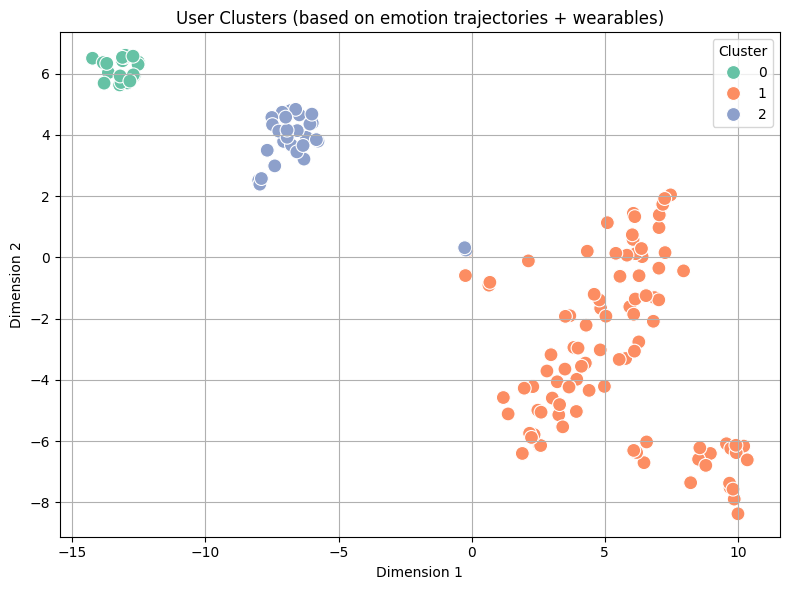

In [65]:
# -----------------------------
# Visualization (UMAP)
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# UMAP alternative: from umap import UMAP
# reducer = UMAP(n_components=2, random_state=42)
reducer = TSNE(n_components=2, perplexity=30.0, random_state=42)
X_2d = reducer.fit_transform(X)

# Add to DataFrame
user_cluster_df["x"] = X_2d[:, 0]
user_cluster_df["y"] = X_2d[:, 1]

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=user_cluster_df, x="x", y="y", hue="cluster", palette="Set2", s=100)
plt.title("User Clusters (based on emotion trajectories + wearables)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


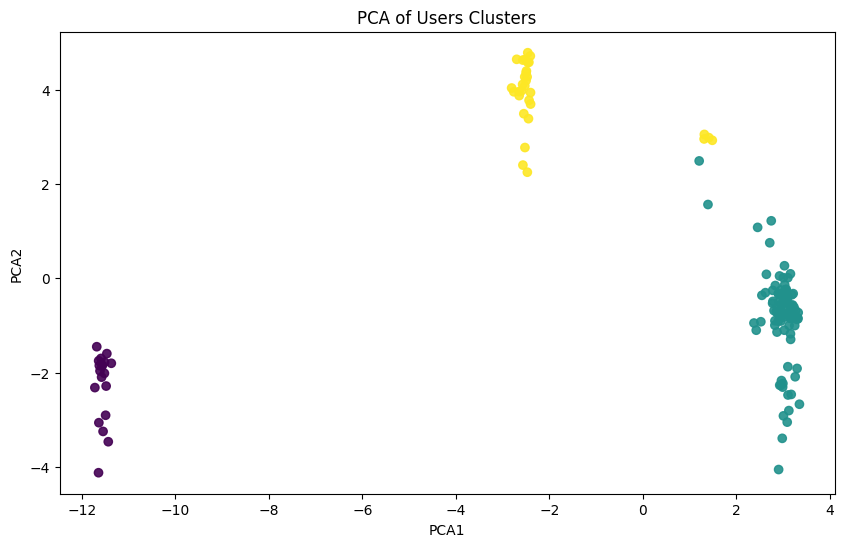

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Add the PCA results to the dataframe
user_cluster_df['PCA1'] = pca_result[:, 0]
user_cluster_df['PCA2'] = pca_result[:, 1]

# Plot the clusters in 2D space
plt.figure(figsize=(10, 6))
plt.scatter(user_cluster_df['PCA1'], user_cluster_df['PCA2'], c=user_cluster_df['cluster'], cmap='viridis', alpha=0.9)
plt.title('PCA of Users Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

plt.show()